In [99]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

from qs_mps.utils import create_sequential_colors

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

font = {'family': 'serif', 'size': 20}
plt.rcParams.update({'font.family': font['family'], 'font.size': font['size']})

model = "Z2_dual"
path = "marcos"
cx = [3,37]
cy = [3,3]
# cx = None
# cy = None

if model == "Ising":
    model_path = "0_ISING"

elif model == "Z2_dual":
    model_path = "1_Z2"
    param_label = "h"
    boundcond = "obc"
    if cx == None:
        sector = "vacuum_sector"
    else:
        sector = f"{len(cx)}_particle(s)_sector"

elif model == "ANNNI":
    model_path = "2_ANNNI"

elif model == "Cluster":
    model_path = "3_CLUSTER"
else:
    raise SyntaxError("Model not valid. Choose among 'Ising', 'Z2', 'ANNNI', 'Cluster'")
# take the path and precision to save files
# if we want to save the tensors we save them locally because they occupy a lot of memory
if path == "pc":
    parent_path = f"C:/Users/HP/Desktop/projects/1_Z2"
    # parent_path = "G:/My Drive/projects/1_Z2"
    path_tensor = "D:/code/projects/1_Z2"
elif path == "mac":
    # parent_path = "/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm98/Desktop/projects/1_Z2"
    parent_path = path_tensor
elif path == "marcos":
    # parent_path = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
    path_tensor = "/Users/fradm/Desktop/projects/1_Z2"
    parent_path = path_tensor

# Charge Sector Analysis

We want to explore the two particle sector of you $Z_2$ pure lattice gauge theory. 
The study of the potential already can tell us more about the physics of the system. 

From the decoupling phase at small values of the Eletric coupling constant $g$, the charges are free so that there is no attractive potential between the two charges. If we express the potential as the difference between the vacuum ground state and the two charges ground state, in the **decoupling phase**, this quantity corresponds to the free energy of the particles.

Entering the confining phase, the energy between the charges forms a string of electric flux which is dominated by fluctuations. This is called the **roughening phase**. This phase is supposed to be dominant for a certain region of coupling values up to the roughening transition which is said to be an infinite order phase transition. 

After the transition, for large values of eletric coupling, the negative electric field is confined along the shortest path separating the two charges, reaching indeed the **confinig phase**.

Thus, we will see in this notebook the potential in these different phases

## Study of the potential $V(g,R)$

The static potential, according with what has been just said, depends on the electric coupling $g$ but also on the distance between the two charges defined as $R$.
The potential in the roughening phase seems to have a correction term

$$ V(g,R) = \sigma R + \mu + \gamma\frac{1}{R} + O\left(\frac{1}{R^2}\right) \quad .$$

But there are systematic and statistical errors to take into account because of our numerical simulations.
The accuracy of the ground state energy is limited by the bond dimension $\chi$ and finite size effects could arise because of the lattice with shape $l$ x $L$.

Thus, we now focus on some specific values of $g,R$, we fix the lattice and find the value of the potential for infinite bond dimension.
Once we have eliminated the dependency of the potential from the bond dimension, we can study the finite size effects. Finally we will get the $V(g,R)$ and we can extract the string tension $\sigma$ and the luscher term $\gamma$.

# Study of the potential $V(g,R,L,\chi)$

The bond dimension $\chi$ is our free parameter

In [149]:
npoints, h_i, h_f, chi = 30, 0.8, 1.0, 128
l, L = 6, 30
R = 24
interval = np.linspace(h_i,h_f,npoints)
g = 0.8

In [150]:
def get_cx(L,R):
    assert 0 < R < L, "The fluxtube is longer than the lattice length"
    return [L//2-R//2,L//2+R//2]

def get_cy(l):
    return [l//2,l//2]

def find_closest_value(interval, g):
    """
    Finds the closest value in the interval to the g.
    If the g is between two values, returns the smaller one.
    
    Parameters:
    interval (list of numbers): The sorted discrete interval values.
    g (number): The value to find the closest match for.
    
    Returns:
    number: The closest value in the interval to the g.
    """
    # Sort the interval in ascending order to simplify comparisons
    interval = sorted(interval)
    
    # Edge cases for targets outside the interval bounds
    if g <= interval[0]:
        print(f"we search for g={interval[0]}")
        return interval[0]
    if g >= interval[-1]:
        print(f"we search for g={interval[-1]}")
        return interval[-1]
    
    # Initialize closest variable to hold the result
    closest = interval[0]
    
    # Traverse the interval to find the closest value
    for value in interval:
        # If the current value is closer to the g, update closest
        if abs(value - g) < abs(closest - g):
            closest = value
        # If the distance is the same but g is between values, choose the smaller one
        elif abs(value - g) == abs(closest - g) and value < closest:
            closest = value
    
    print(f"we search for g={closest}")
    return closest

In [151]:
def static_potential(g,R,l,L,chi):
    cx = get_cx(L,R)
    cy = get_cy(l)
    energy_charges = np.load(f"{path_tensor}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_{sector}_bc_{boundcond}_{cx}-{cy}_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    energy_vacuum = np.load(f"{path_tensor}/results/energy_data/energy_Z2_dual_direct_lattice_{l}x{L}_vacuum_sector_bc_{boundcond}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy")
    energy_difference = np.abs(energy_charges - energy_vacuum)

    for i, val in enumerate(energy_difference):
        if round(g,3) == round(interval[i],3):
            return val
        
def static_potential_chis(g,R,l,L,chis):
    st_pots = []
    for chi in chis:
        st_pot = static_potential(g,R,l,L,chi)
        st_pots.append(st_pot)
    return st_pots

In [152]:
chis = [16,32,64,128]
g = find_closest_value(interval, g)
potentials = static_potential_chis(g,R,l,L,chis)

we search for g=0.8


<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_93991/2777465946.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("$1/\chi$")
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_93991/2777465946.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.title("Static Potential $V(g,R,l$x$L)$ $vs$ $1/\chi$")


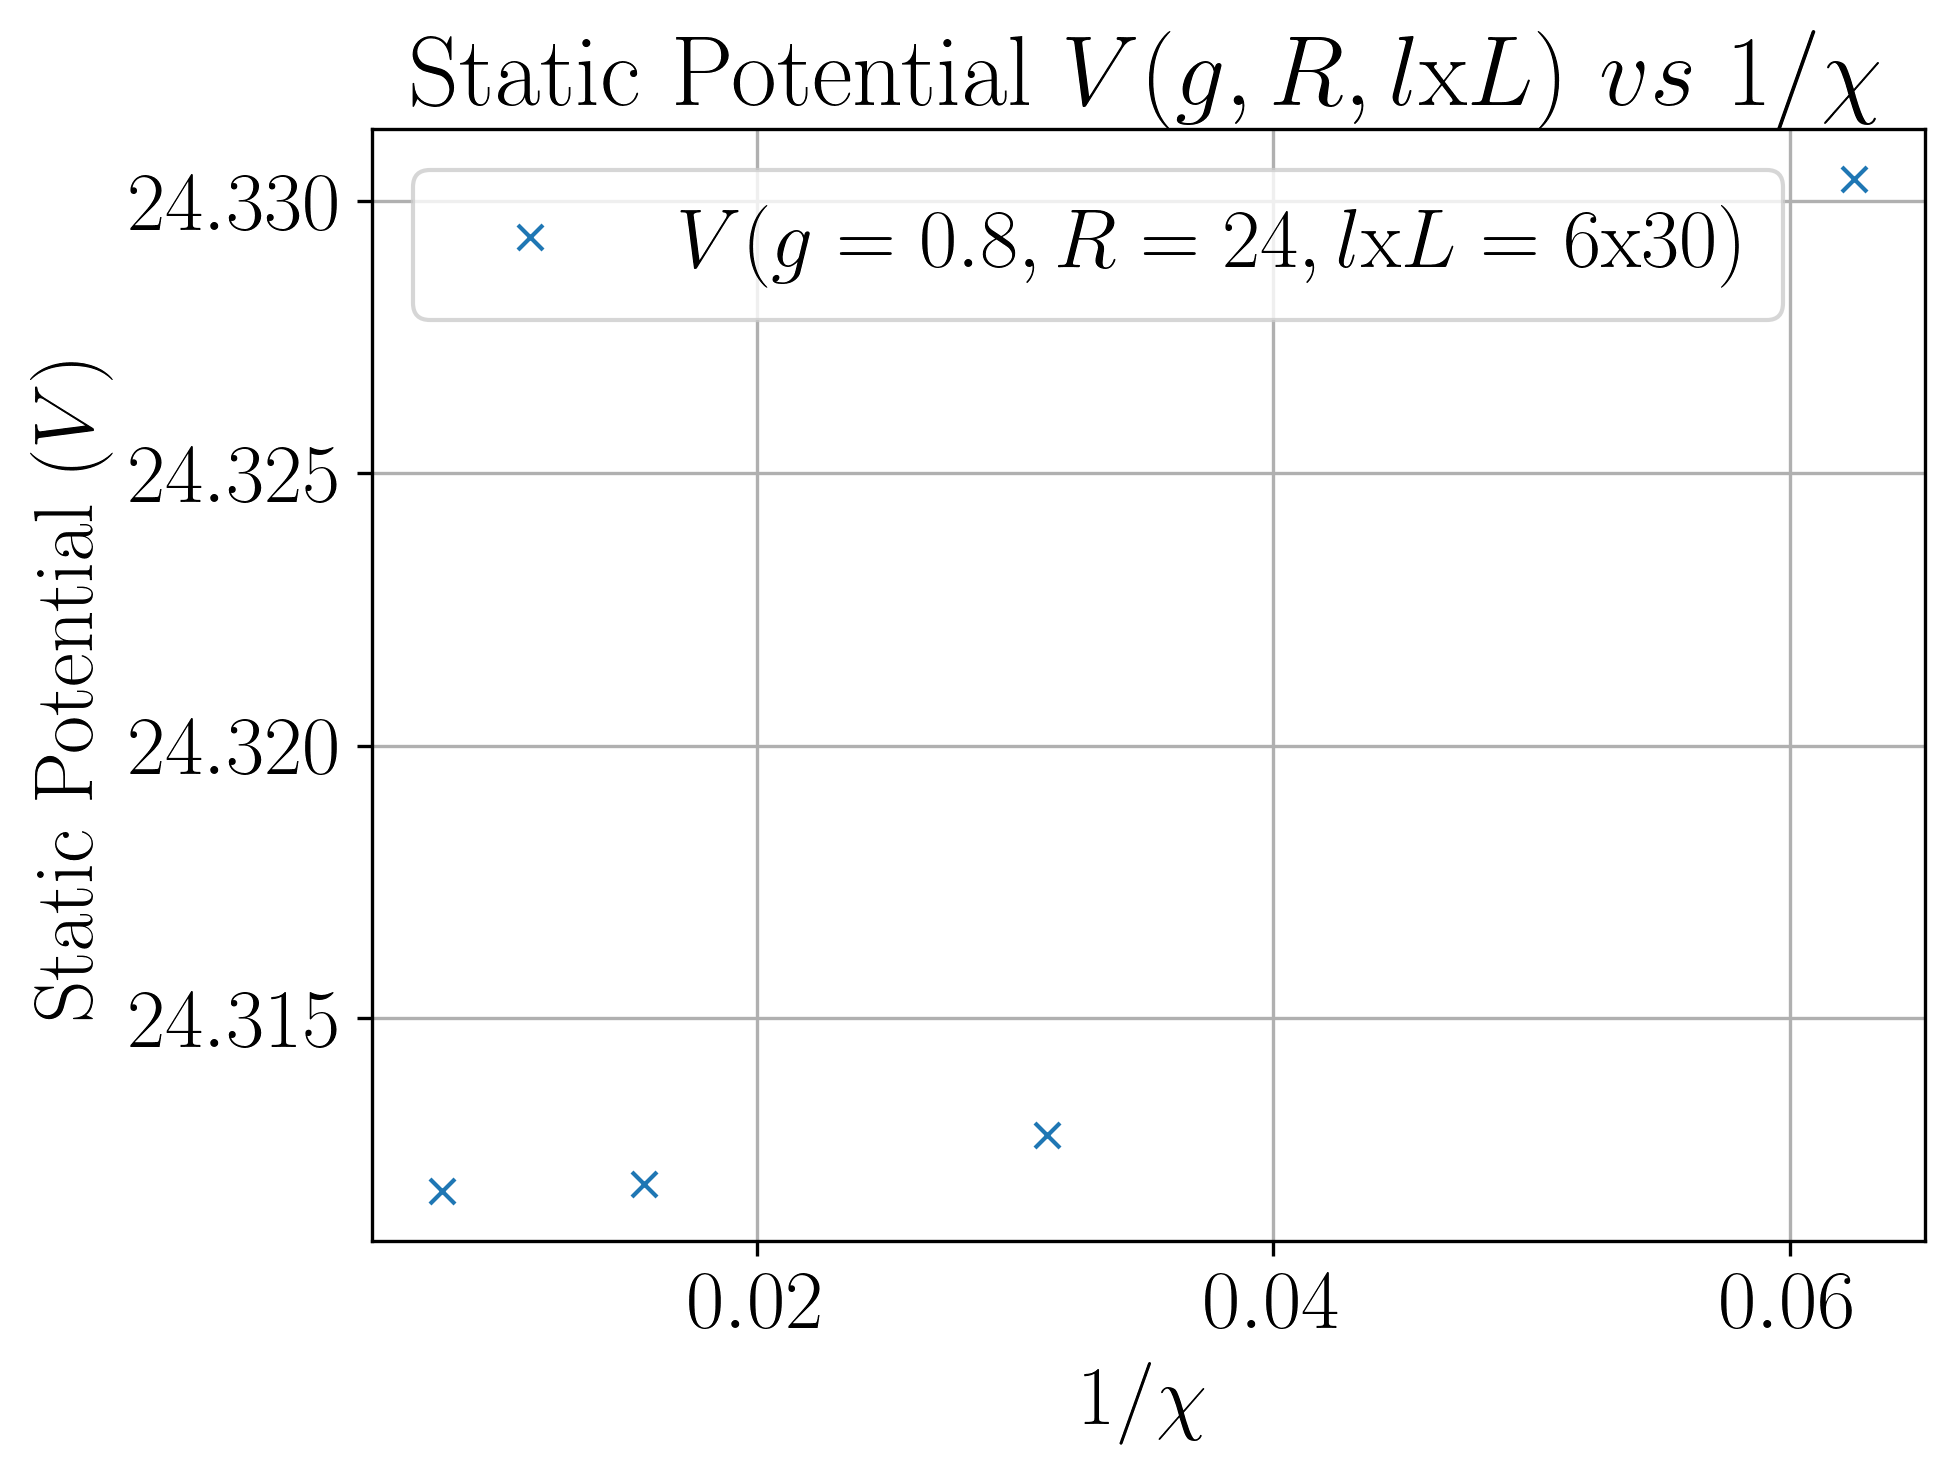

In [153]:
plt.plot([1/chi for chi in chis], potentials, 'x', label=f"$V(g={round(g,2)}, R={R}, l$x$L={l}$x${L})$")

plt.xlabel("$1/\chi$")
plt.ylabel("Static Potential $(V)$")
plt.title("Static Potential $V(g,R,l$x$L)$ $vs$ $1/\chi$")
plt.legend()
plt.grid(True)


<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:37: SyntaxWarning: invalid escape sequence '\c'
<>:39: SyntaxWarning: invalid escape sequence '\c'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_93991/1176302655.py:31: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(1/x_fit, y_fit, linewidth=1, linestyle="--", label=f'Fit: $V = {y0_fit:.2f} + {A_fit:.2f} e^{{-{B_fit:.2f} \chi}}$', color='red')
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_93991/1176302655.py:37: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel("$1/\chi$")
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_93991/1176302655.py:39: SyntaxWarning: invalid escape sequence '\c'
  plt.title('Asymptotic Fit $vs$ $1/\chi$')


Fitted parameters:
y0 (asymptotic value) = 24.311877 ± 0.000057
A = 0.357786 ± 0.035906
B = 0.185052 ± 0.006361


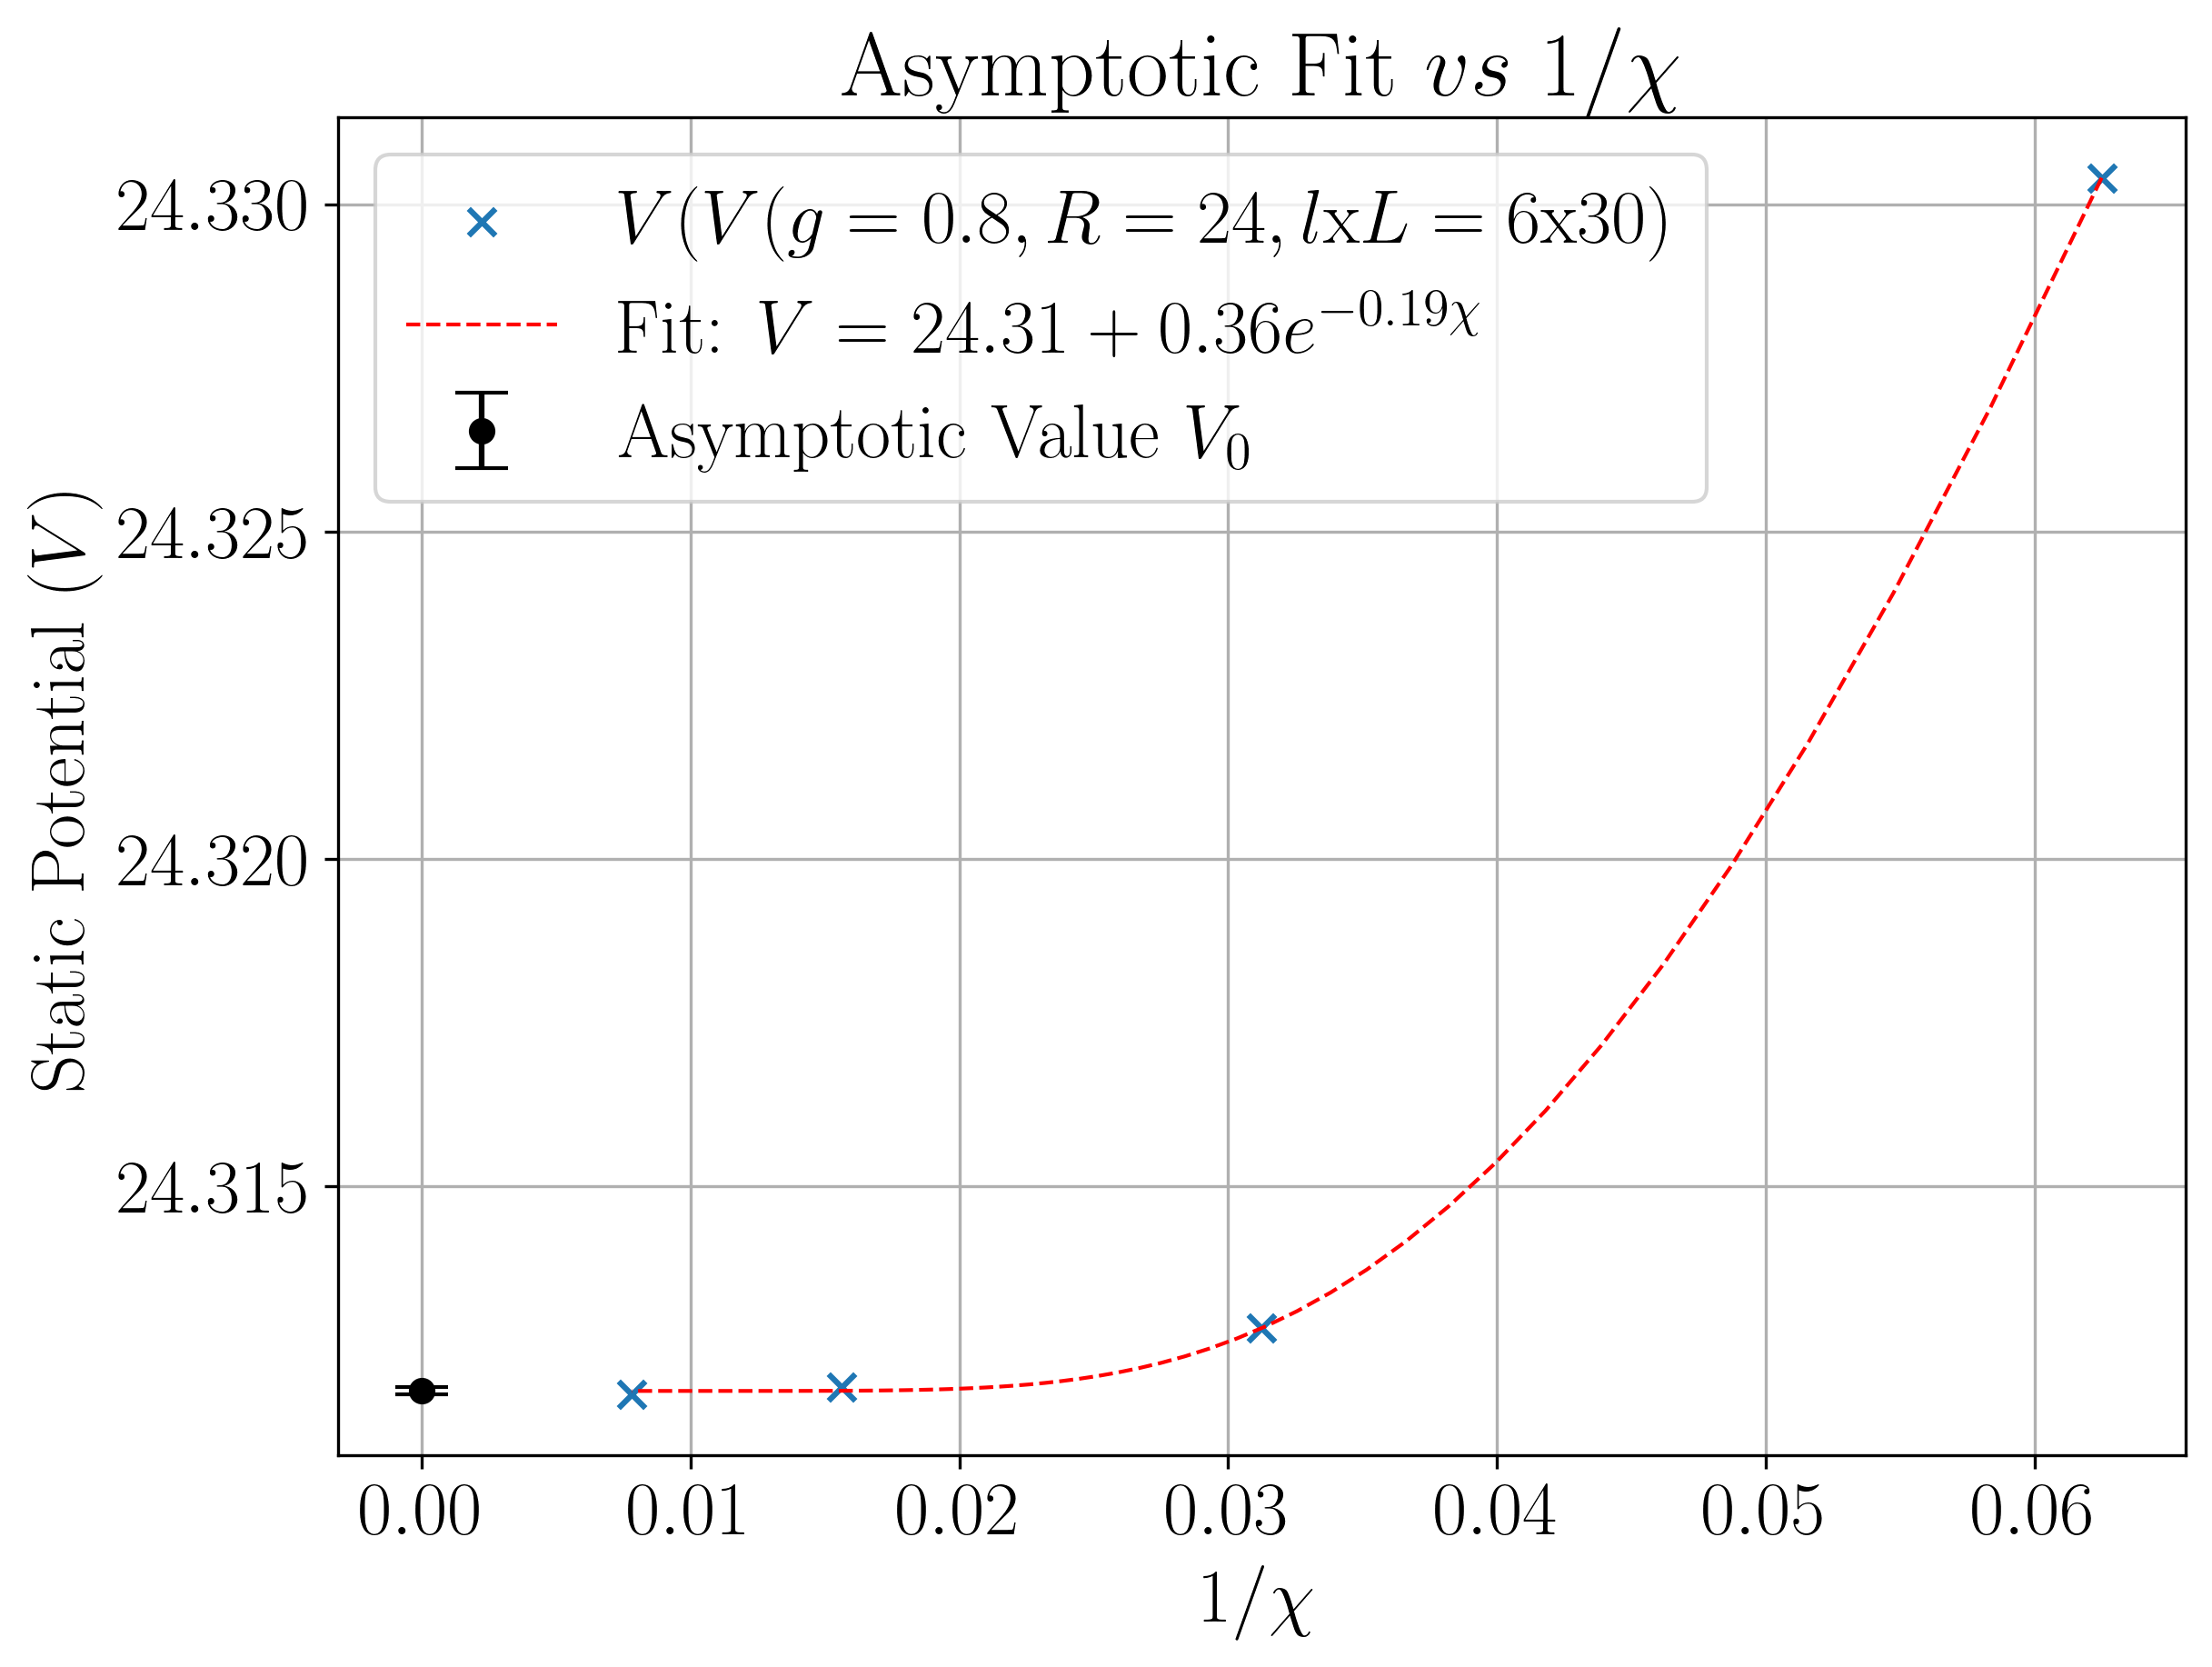

In [155]:
# Given data
x_data = chis
y_data = potentials

# Convert x_data to 1/x for plotting
x_inv_data = [1/chi for chi in chis]

# Define the model function with asymptotic behavior
def asymptotic_model(x, y0, A, B):
    return y0 + A * np.exp(-B * x)

# Fit the model to the data
popt, pcov = curve_fit(asymptotic_model, x_data, y_data, p0=(y_data[-1], 0.1, 0.1))

# Extract fitted parameters and their errors
y0_fit, A_fit, B_fit = popt
y0_err, A_err, B_err = np.sqrt(np.diag(pcov))

print(f"Fitted parameters:")
print(f"y0 (asymptotic value) = {y0_fit:.6f} ± {y0_err:.6f}")
print(f"A = {A_fit:.6f} ± {A_err:.6f}")
print(f"B = {B_fit:.6f} ± {B_err:.6f}")

# Generate data for the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = asymptotic_model(x_fit, *popt)

# Plot the data and the fit with respect to 1/x
plt.figure(figsize=(8, 6))
plt.scatter(x_inv_data, y_data, marker='x', s=50, label=f"$V(V(g={round(g,2)}, R={R}, l$x$L={l}$x${L})$")
plt.plot(1/x_fit, y_fit, linewidth=1, linestyle="--", label=f'Fit: $V = {y0_fit:.2f} + {A_fit:.2f} e^{{-{B_fit:.2f} \chi}}$', color='red')

# Plot the asymptotic value at 1/x = 0 with error bar
plt.errorbar(0, y0_fit, yerr=y0_err, fmt='o', color='black', capsize=7, label='Asymptotic Value $V_0$')

# Customize the plot
plt.xlabel("$1/\chi$")
plt.ylabel("Static Potential $(V)$")
plt.title('Asymptotic Fit $vs$ $1/\chi$')
plt.legend()
plt.grid(True)

plt.show()


We have found that, taking small and large bond dimensions $\chi$, the best fit is the exponential one.
Now we can iterate for different values of $g$ and $R$ to move to the next step, that is, taking care of finite size lattice effects.

In [156]:
def get_exact_potential_chis(chis, potentials):
    # Given data
    x_data = chis
    y_data = potentials
    x_inv_data = [1/chi for chi in chis]

    # Define the model function with asymptotic behavior
    def asymptotic_model(x, y0, A, B):
        exponent = np.clip(-B * x, -700, 700)
        return y0 + A * np.exp(exponent)

    # Fit the model to the data
    popt, pcov = curve_fit(asymptotic_model, x_data, y_data, p0=(y_data[-1], 0.1, 0.1))

    # Extract fitted parameters and their errors
    y0_fit, A_fit, B_fit = popt
    y0_err, A_err, B_err = np.sqrt(np.diag(pcov))
    print(f"y0 (asymptotic value) = {y0_fit:.6f} ± {y0_err:.6f}")
    return y0_fit, y0_err

def static_potential_exact_chi(g,R,l,L,chis):
    potentials = static_potential_chis(g,R,l,L,chis)
    pot_exact, err = get_exact_potential_chis(chis, potentials)
    return pot_exact, err

def static_potential_varying_R(g,Rs,l,L,chis):
    potentials = []
    err_potentials = []
    for R in Rs:
        print(f"R: {R}")
        pot, err = static_potential_exact_chi(g,R,l,L,chis)
        potentials.append(pot)
        err_potentials.append(err)

    return potentials, err_potentials

def static_potential_varying_g(gs,R,l,L,chis):
    potentials = []
    err_potentials = []
    for g in gs:
        print(f"g: {g}")
        pot, err = static_potential_exact_chi(g,R,l,L,chis)
        potentials.append(pot)
        err_potentials.append(err)

    return potentials, err_potentials

In [159]:
Rs = [20,22,24]
gs = interval

g = 0.8
potentials_exact_varying_R, err_R = static_potential_varying_R(g,Rs,l,L,chis)

R = 24
potentials_exact_varying_g, err_g = static_potential_varying_g(gs,R,l,L,chis)

R: 20
y0 (asymptotic value) = 20.317440 ± 0.000034
R: 22
y0 (asymptotic value) = 22.314670 ± 0.000045
R: 24
y0 (asymptotic value) = 24.311877 ± 0.000057
g: 0.8
y0 (asymptotic value) = 24.311877 ± 0.000057
g: 0.806896551724138
y0 (asymptotic value) = 24.979697 ± 0.000061
g: 0.8137931034482759
y0 (asymptotic value) = 25.641834 ± 0.000065
g: 0.8206896551724139
y0 (asymptotic value) = 26.298213 ± 0.000061
g: 0.8275862068965517
y0 (asymptotic value) = 26.948785 ± 0.000061
g: 0.8344827586206897
y0 (asymptotic value) = 27.593490 ± 0.000057
g: 0.8413793103448276
y0 (asymptotic value) = 28.232294 ± 0.000063
g: 0.8482758620689655
y0 (asymptotic value) = 28.865134 ± 0.000058
g: 0.8551724137931035
y0 (asymptotic value) = 29.491974 ± 0.000051
g: 0.8620689655172414
y0 (asymptotic value) = 30.112789 ± 0.000053
g: 0.8689655172413794
y0 (asymptotic value) = 30.727526 ± 0.000052
g: 0.8758620689655172
y0 (asymptotic value) = 31.336143 ± 0.000046
g: 0.8827586206896552
y0 (asymptotic value) = 31.938608 ± 0

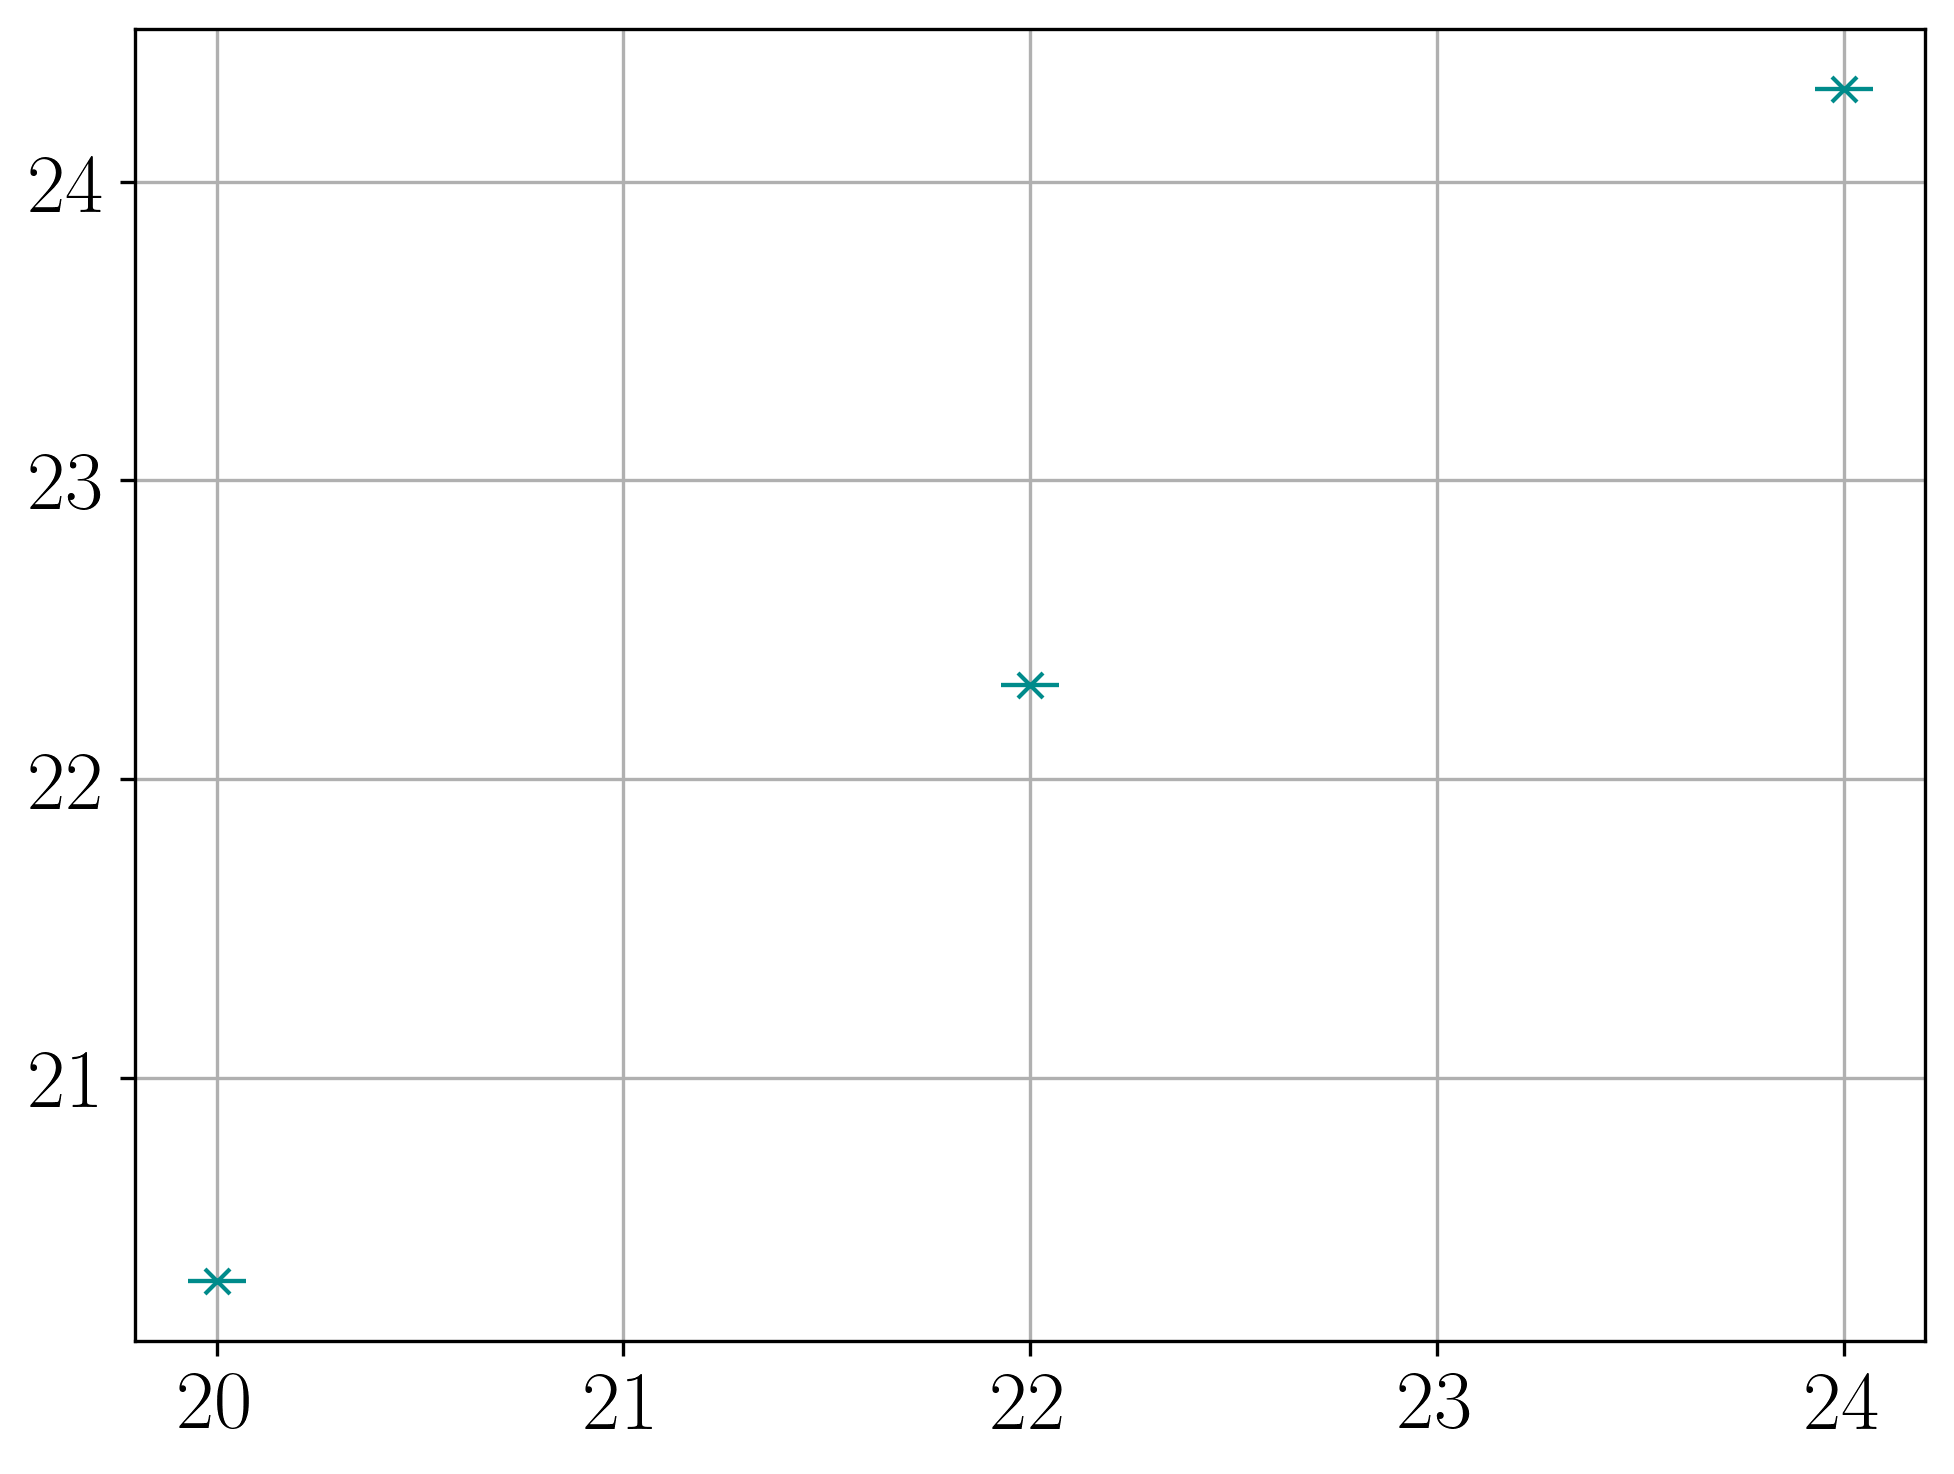

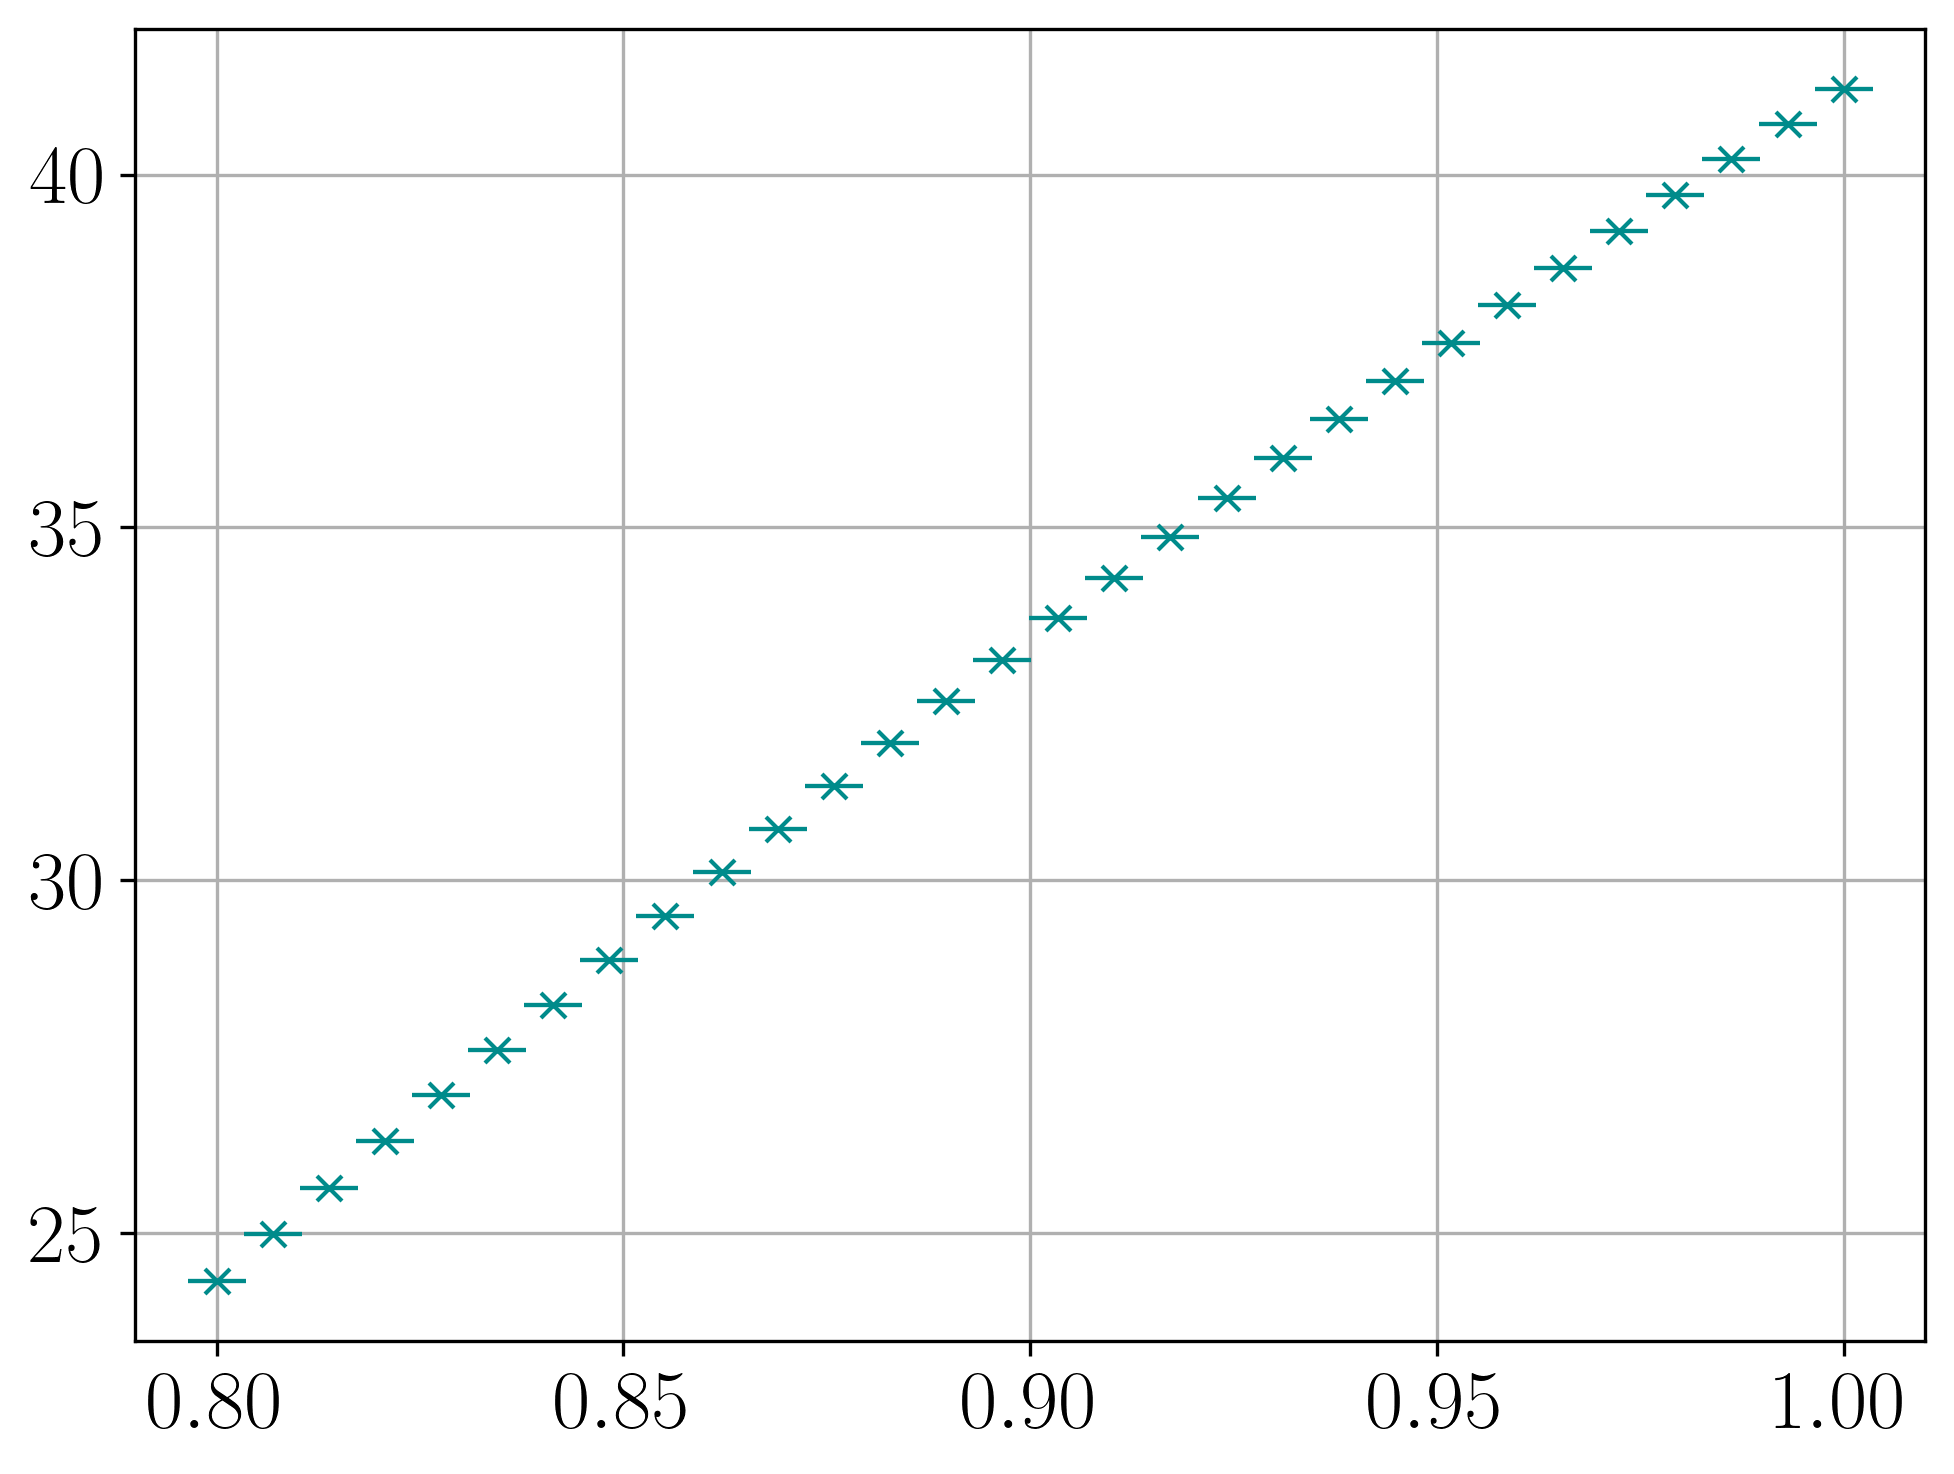

In [162]:
plt.errorbar(Rs, potentials_exact_varying_R, yerr=err_R, fmt='x', color='darkcyan', capsize=7)
plt.grid(True)
plt.show()
plt.errorbar(gs, potentials_exact_varying_g, yerr=err_g, fmt='x', color='darkcyan', capsize=7)
plt.grid(True)
plt.show()

# Study of the potential $V(g,R,L)$

Now we fix $g$ and $R$ and, by taking the values of V obtained for infinite $\chi$ we determine the finite size effect of our lattice in the $L$ direction.

In [161]:
def static_potential_Ls(g,R,l,Ls,chis):
    potentials = []
    potentials_err = []
    for L in Ls:
        pot, err = static_potential_exact_chi(g,R,l,L,chis)
        potentials.append(pot)
        potentials_err.append(err)
    return potentials, potentials_err

In [164]:
Ls = [30,40]
g = 0.8
R = 24
potentials_varying_L, err_L = static_potential_Ls(g,R,l,Ls,chis)

y0 (asymptotic value) = 24.311877 ± 0.000057
y0 (asymptotic value) = 24.311818 ± 0.000060


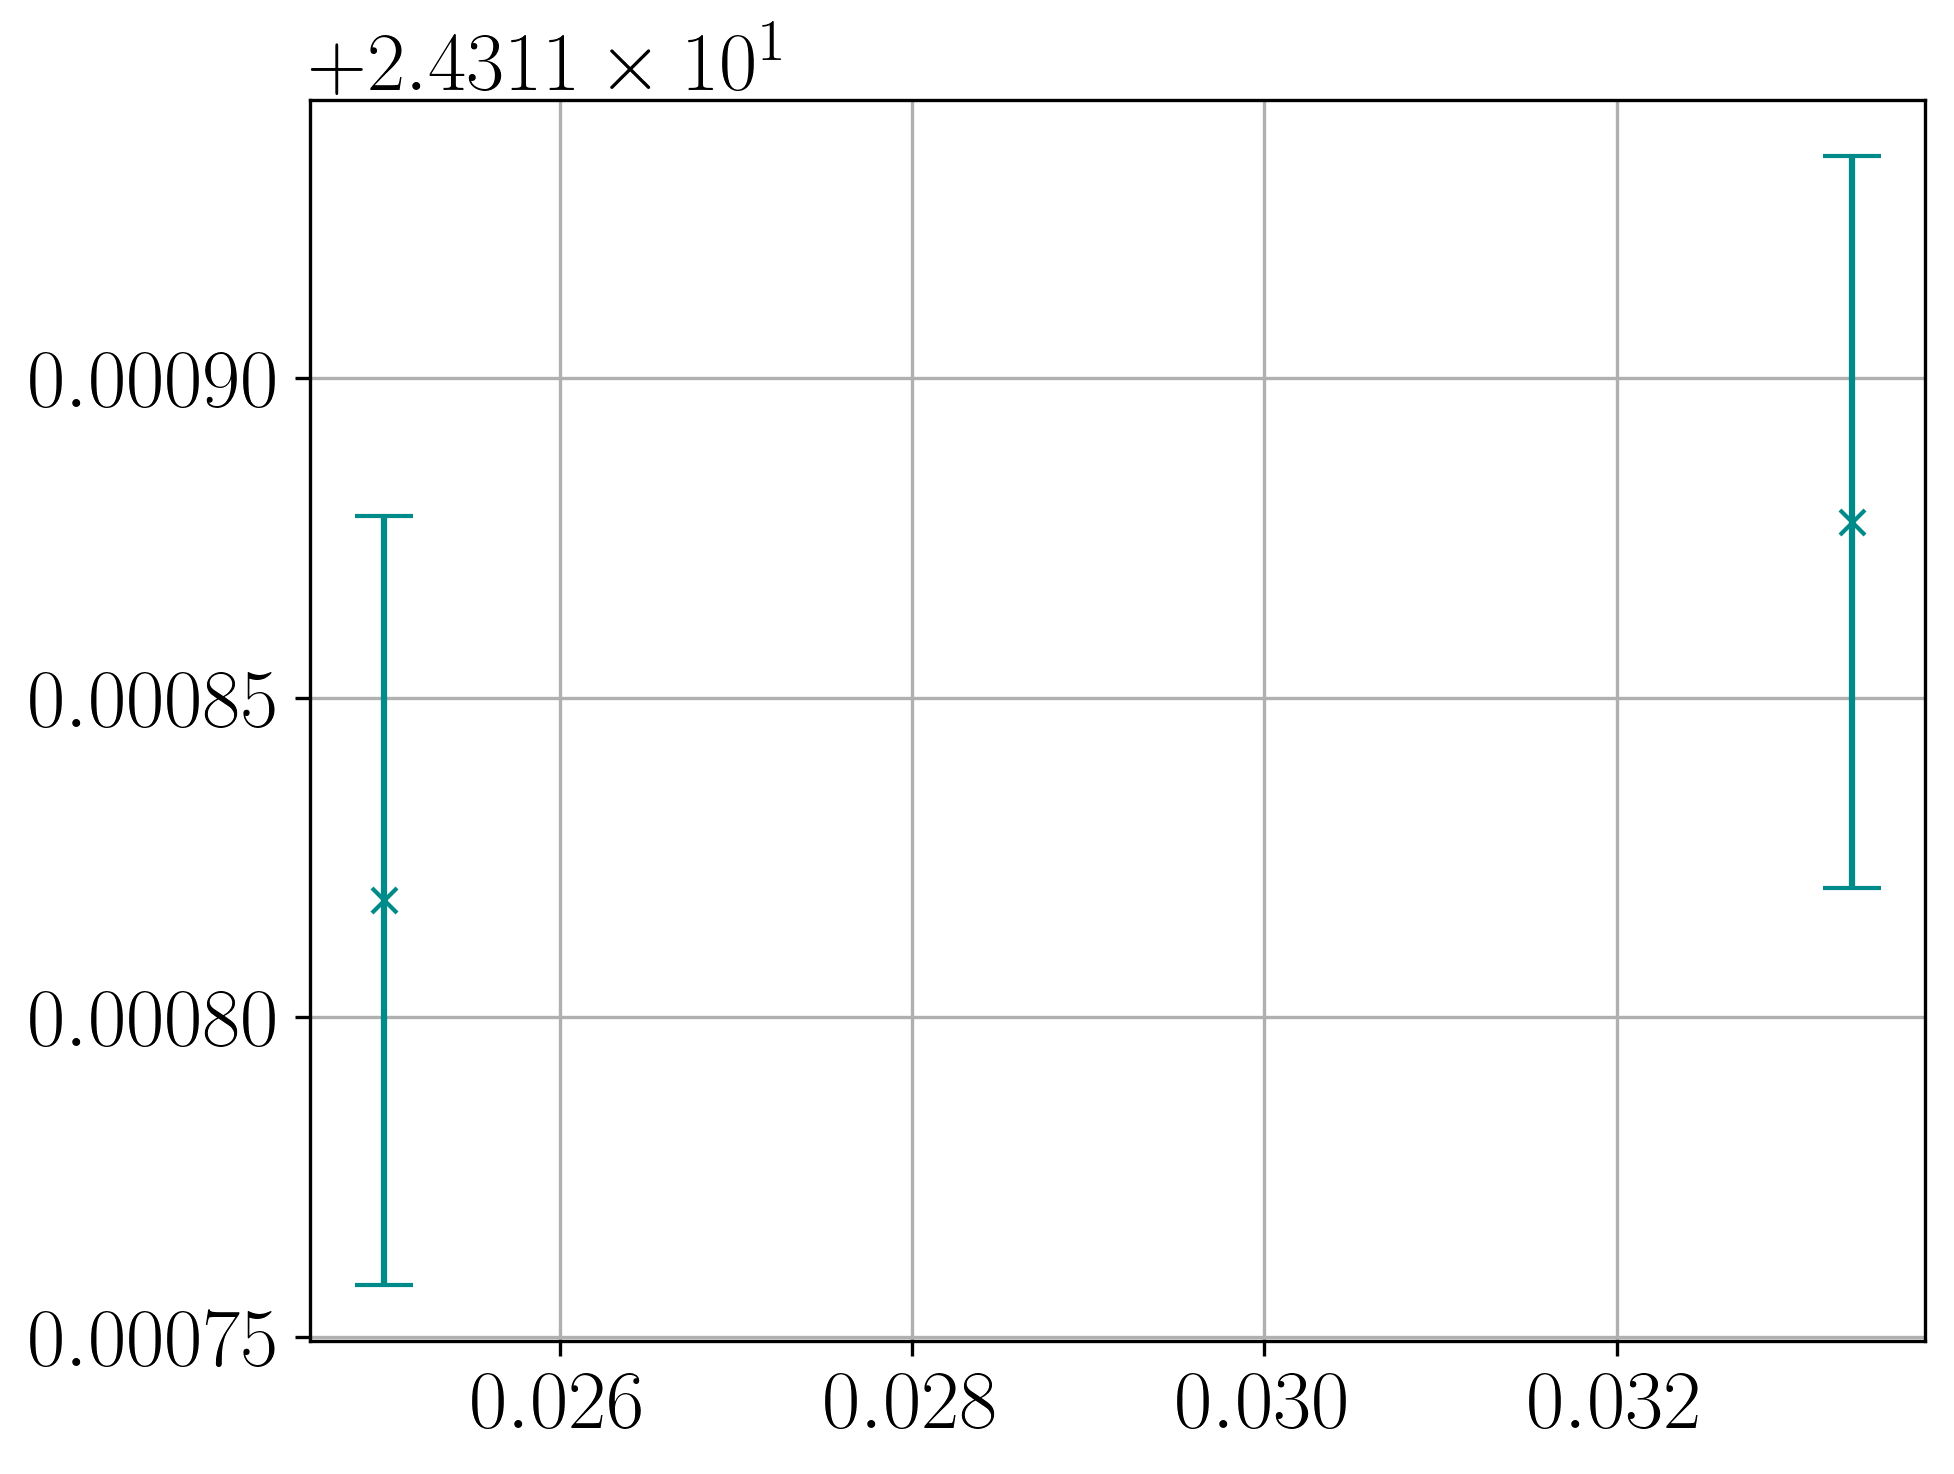

In [166]:
plt.errorbar([1/L for L in Ls], potentials_varying_L, yerr=err_L, fmt='x', color='darkcyan', capsize=7)
plt.grid(True)
plt.show()

Next steps:
- make a fit (probably linear) taking into account the errors of the V found for exact bond dimension
- get the value for infinite $L$
- now we can find the potential with limited error due to mps approx and finite lattice, for different values of $g$ and $R$
- use these values of the potential to make derivative or fits to find the luscher term and the string tension